---
author: Darren Biskup, Han He
date: 10 08 2025
title: Lab3 - Assignment 5

jupyter: python3
embed-resources: true
---

### Parse Rosbag

In [2]:
import numpy as np

from pathlib import Path

from rosbags.highlevel import AnyReader
from rosbags.typesys import Stores, get_typestore

bagpath = Path('./door_data_bag')

# Create a type store to use if the bag has no message definitions.
typestore = get_typestore(Stores.ROS2_FOXY)

torque_list = []         # will hold (timestamp, torque)
feature_mean_list = []   # will hold (timestamp, feature_mean)

# Create reader instance and open for reading.
with AnyReader([bagpath], default_typestore=typestore) as reader:
    connections = [x for x in reader.connections]

    for c in connections:
        print(f"Topic: {c.topic}  Type: {c.msgtype}")

    for connection, timestamp, rawdata in reader.messages(connections=connections):
         msg = reader.deserialize(rawdata, connection.msgtype)
         if connection.topic == "/hinged_glass_door/torque" and hasattr(msg, "data"):
             torque_list.append((timestamp, float(msg.data)))
         elif connection.topic == "/feature_mean" and hasattr(msg, "data"):
             feature_mean_list.append((timestamp, float(msg.data)))

torque_array = np.array(torque_list)
feature_mean_array = np.array(feature_mean_list)

print("Collected:", len(torque_list), "torque samples;",
       len(feature_mean_list), "feature_mean samples")


Topic: /hinged_glass_door/torque  Type: std_msgs/msg/Float64
Topic: /feature_mean  Type: std_msgs/msg/Float64
Collected: 95 torque samples; 2478 feature_mean samples


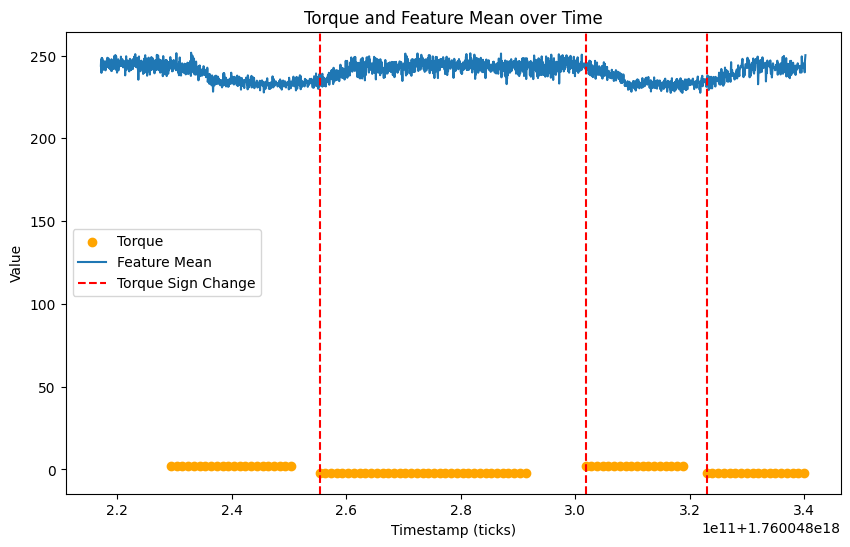

In [7]:
import matplotlib.pyplot as plt

torque_signs = np.sign(torque_array[:, 1])
sign_changes = np.where((torque_signs[:-1] != torque_signs[1:]) & 
                        (torque_signs[:-1] != 0) & 
                        (torque_signs[1:] != 0))[0] + 1
change_timestamps = torque_array[sign_changes, 0]

plt.figure(figsize=(10, 6))
plt.scatter(torque_array[:, 0], torque_array[:, 1], 
            label='Torque', color='orange')
plt.plot(feature_mean_array[:, 0], feature_mean_array[:, 1], 
         label='Feature Mean')

# Add vertical lines at sign changes
for ts in change_timestamps:
    plt.axvline(x=ts, color='red', linestyle='--', 
                label='Torque Sign Change' if ts == change_timestamps[0] else "")

plt.xlabel('Timestamp (ticks)')
plt.ylabel('Value')
plt.title('Torque and Feature Mean over Time')
plt.legend()
plt.show()

### We will discard all data samples before the first torque sign change, since the scene was not ready
*update 10/10 no longer discarding beginning*

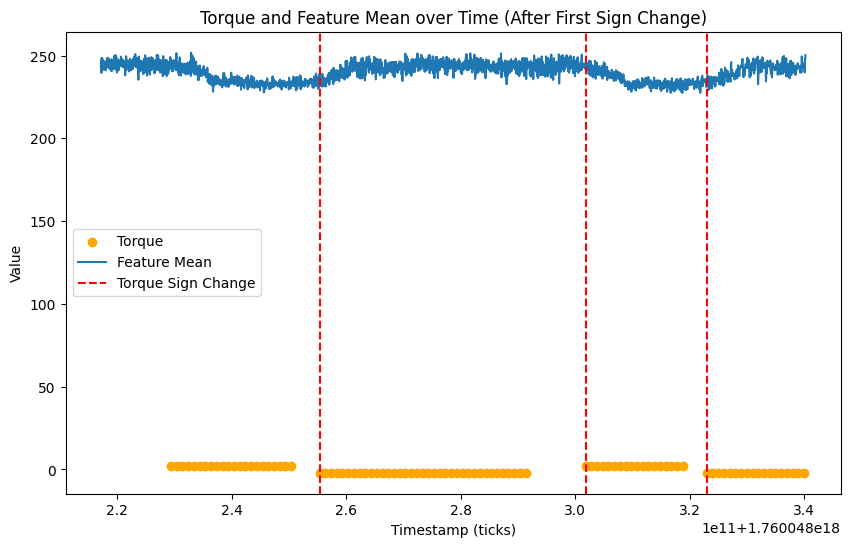

In [ ]:
first_ts = 0 # no longer need to discard anything after recollecting data

torque_filtered = torque_array[torque_array[:, 0] >= first_ts]
feature_mean_filtered = feature_mean_array[feature_mean_array[:, 0] >= first_ts]

torque_signs_filtered = np.sign(torque_filtered[:, 1])
sign_changes_filtered = (np.where((torque_signs_filtered[:-1] != torque_signs_filtered[1:]) & 
                                   (torque_signs_filtered[:-1] != 0) & 
                                   (torque_signs_filtered[1:] != 0))[0] + 1)
change_timestamps_filtered = torque_filtered[sign_changes_filtered, 0]

plt.figure(figsize=(10, 6))
plt.scatter(torque_filtered[:, 0], torque_filtered[:, 1], label='Torque', color='orange')
plt.plot(feature_mean_filtered[:, 0], feature_mean_filtered[:, 1], label='Feature Mean')

for ts in change_timestamps_filtered:
    plt.axvline(x=ts, color='red', linestyle='--', 
                label='Torque Sign Change' if ts == change_timestamps_filtered[0] else "")

plt.xlabel('Timestamp (ticks)')
plt.ylabel('Value')
plt.title('Torque and Feature Mean over Time (After First Sign Change)')
plt.legend()
plt.show()

### We also need to discard all data samples 8 seconds after a torque switch to allow the door to fully change state

In [19]:
import numpy as np

seg1_end_idx = sign_changes_filtered[0] - 1
seg2_start_idx = sign_changes_filtered[0]
seg2_end_idx = sign_changes_filtered[1] - 1
seg3_start_idx = sign_changes_filtered[1]

discard_count = 8

start_ts_neg1 = (torque_filtered[discard_count, 0] 
                 if seg1_end_idx - 0 + 1 > discard_count 
                 else float('inf'))
start_ts_neg3 = (torque_filtered[seg3_start_idx + discard_count, 0] 
                 if len(torque_filtered) - seg3_start_idx > discard_count 
                 else float('inf'))

mask_neg = (((feature_mean_filtered[:, 0] >= start_ts_neg1) & 
             (feature_mean_filtered[:, 0] <= torque_filtered[seg1_end_idx, 0])) | 
            ((feature_mean_filtered[:, 0] >= start_ts_neg3) & 
             (feature_mean_filtered[:, 0] <= torque_filtered[-1, 0])))
feature_mean_negative = feature_mean_filtered[mask_neg]

mask_torque_neg = (((torque_filtered[:, 0] >= start_ts_neg1) & 
                    (torque_filtered[:, 0] <= torque_filtered[seg1_end_idx, 0])) | 
                   ((torque_filtered[:, 0] >= start_ts_neg3) & 
                    (torque_filtered[:, 0] <= torque_filtered[-1, 0])))
torque_negative = torque_filtered[mask_torque_neg]

start_ts_pos = (torque_filtered[seg2_start_idx + discard_count, 0] 
                if seg2_end_idx - seg2_start_idx + 1 > discard_count 
                else float('inf'))

mask_pos = ((feature_mean_filtered[:, 0] >= start_ts_pos) & 
            (feature_mean_filtered[:, 0] <= torque_filtered[seg2_end_idx, 0]))
feature_mean_positive = feature_mean_filtered[mask_pos]

mask_torque_pos = ((torque_filtered[:, 0] >= start_ts_pos) & 
                   (torque_filtered[:, 0] <= torque_filtered[seg2_end_idx, 0]))
torque_positive = torque_filtered[mask_torque_pos]


Original feature_mean_negative length: 450
Filtered feature_mean_negative length: 450
Feature mean negative length: 450
Feature mean positive length: 450


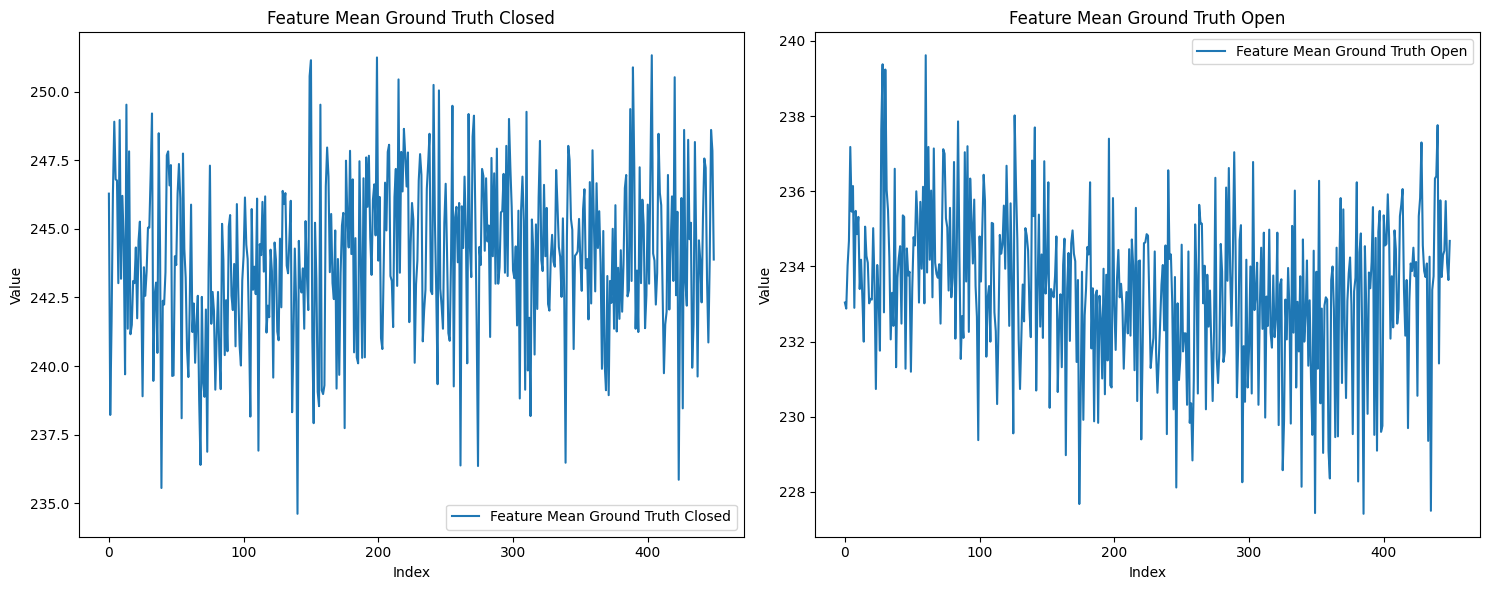

In [37]:
# Filter feature_mean_negative to keep only entries up to index 450
print(f"Original feature_mean_negative length: {len(feature_mean_negative)}")
feature_mean_negative = feature_mean_negative[:450]
print(f"Filtered feature_mean_negative length: {len(feature_mean_negative)}")

# Swap feature_mean_negative and feature_mean_positive since they were incorrectly labeled
feature_mean_temp = feature_mean_negative
feature_mean_negative = feature_mean_positive
feature_mean_positive = feature_mean_temp


print(f"Feature mean negative length: {len(feature_mean_negative)}")
print(f"Feature mean positive length: {len(feature_mean_positive)}")

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(np.arange(len(feature_mean_negative)), feature_mean_negative[:, 1], label='Feature Mean Ground Truth Closed')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Feature Mean Ground Truth Closed')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(feature_mean_positive)), feature_mean_positive[:, 1], label='Feature Mean Ground Truth Open')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Feature Mean Ground Truth Open')
plt.legend()

plt.tight_layout()
plt.show()

### Computing Probabilities with Threshold 237

We will compute four probabilities using a decision threshold of 237 for the feature mean values. This threshold helps classify the door state based on the feature mean signal.

- **For ground truth closed (feature_mean_negative):**
    - Count the number of samples where `feature_mean < 237`. This gives the count for P(z=open|x=closed).
    - P(z=open|x=closed) = (count of feature_mean < 237) / len(feature_mean_negative)
    - P(z=closed|x=closed) = 1 - P(z=open|x=closed)

- **For ground truth open (feature_mean_positive):**
    - Count the number of samples where `feature_mean > 237`. This gives the count for P(z=closed|x=open).
    - P(z=closed|x=open) = (count of feature_mean > 237) / len(feature_mean_positive)
    - P(z=open|x=open) = 1 - P(z=closed|x=open)

In [38]:
threshold = 237

# For ground truth closed (feature_mean_negative)
count_open_given_closed = np.sum(feature_mean_negative[:, 1] < threshold)
p_open_given_closed = count_open_given_closed / len(feature_mean_negative)
p_closed_given_closed = 1 - p_open_given_closed
indices_open_given_closed = np.where(feature_mean_negative[:, 1] < threshold)[0]

print(f"P(z=open|x=closed): {p_open_given_closed}")
print(f"P(z=closed|x=closed): {p_closed_given_closed}")

# For ground truth open (feature_mean_positive)
count_closed_given_open = np.sum(feature_mean_positive[:, 1] > threshold)
p_closed_given_open = count_closed_given_open / len(feature_mean_positive)
p_open_given_open = 1 - p_closed_given_open
indices_closed_given_open = np.where(feature_mean_positive[:, 1] > threshold)[0]

print(f"P(z=closed|x=open): {p_closed_given_open}")
print(f"P(z=open|x=open): {p_open_given_open}")


P(z=open|x=closed): 0.02
P(z=closed|x=closed): 0.98
P(z=closed|x=open): 0.03777777777777778
P(z=open|x=open): 0.9622222222222222


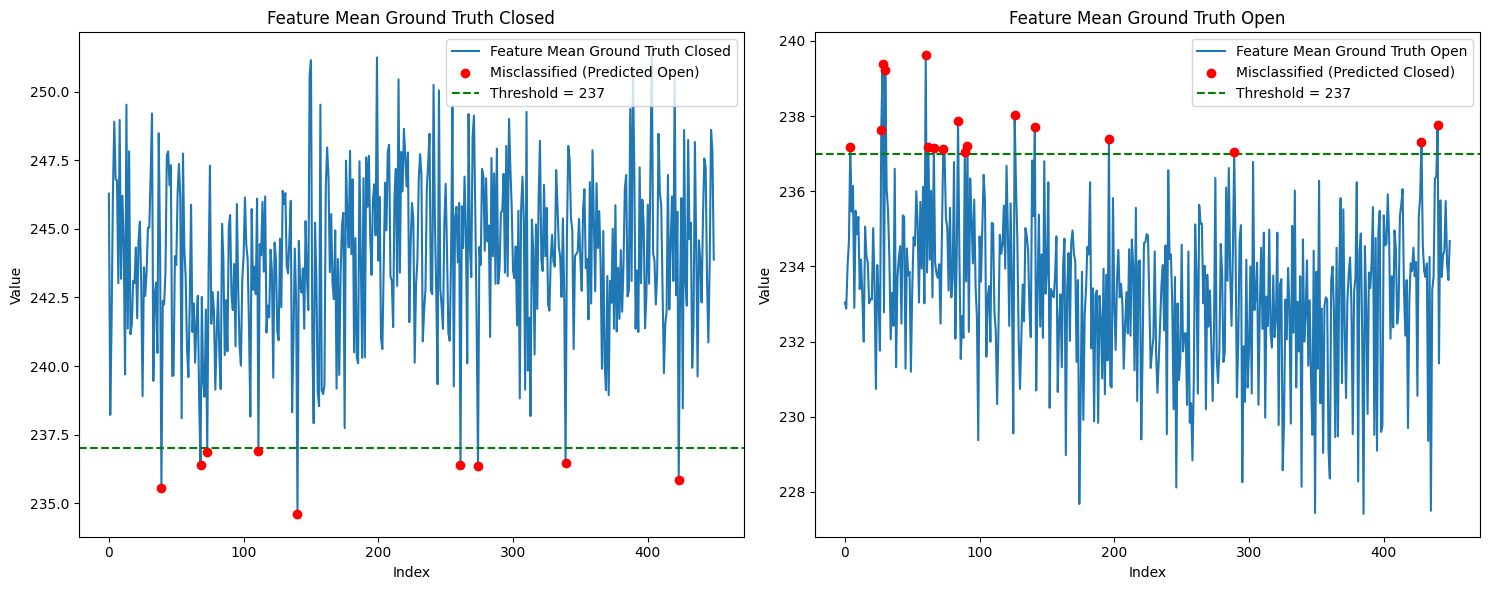

In [39]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(np.arange(len(feature_mean_negative)), feature_mean_negative[:, 1], label='Feature Mean Ground Truth Closed')
plt.scatter(indices_open_given_closed, feature_mean_negative[indices_open_given_closed, 1],
             color='red', label='Misclassified (Predicted Open)', zorder=5)
plt.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Feature Mean Ground Truth Closed')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(feature_mean_positive)), feature_mean_positive[:, 1], label='Feature Mean Ground Truth Open')
plt.scatter(indices_closed_given_open, feature_mean_positive[indices_closed_given_open, 1],
             color='red', label='Misclassified (Predicted Closed)', zorder=5)
plt.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Feature Mean Ground Truth Open')
plt.legend()

plt.tight_layout()
plt.show()